In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [1]:
# датасет производства пива в Австрии по месяцам
df = pd.read_csv("hw_daily-temperatures.csv", index_col=['date'], parse_dates=True)

NameError: name 'pd' is not defined

In [5]:
df.head()

,temp
date,
1987-10-18,10.1
1987-10-19,11.3
1987-10-20,10.4
1987-10-21,10.9
1987-10-22,9.2


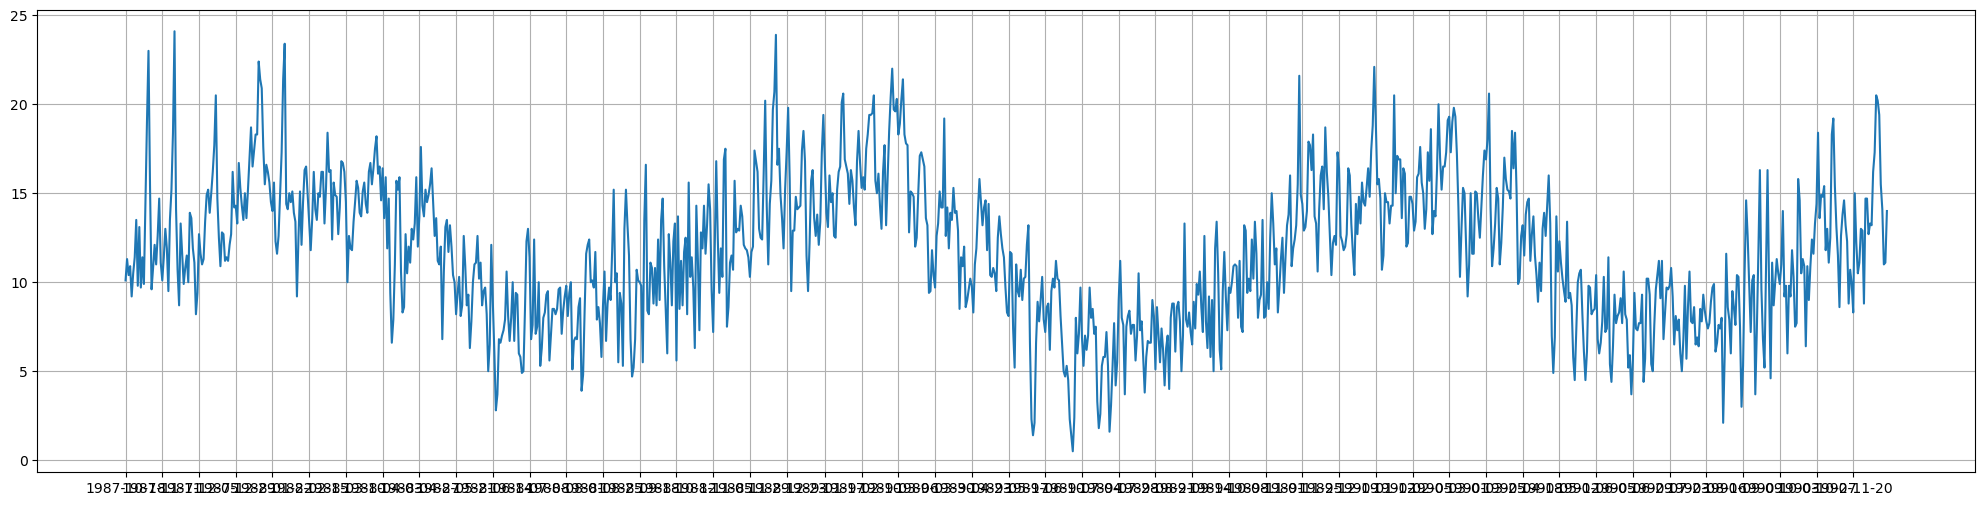

In [7]:
plt.figure(figsize=(25, 6))
plt.plot(df['temp'])
plt.xticks([df.index[i] for i in range(0, len(df), 24)])
plt.grid(True)
plt.show()

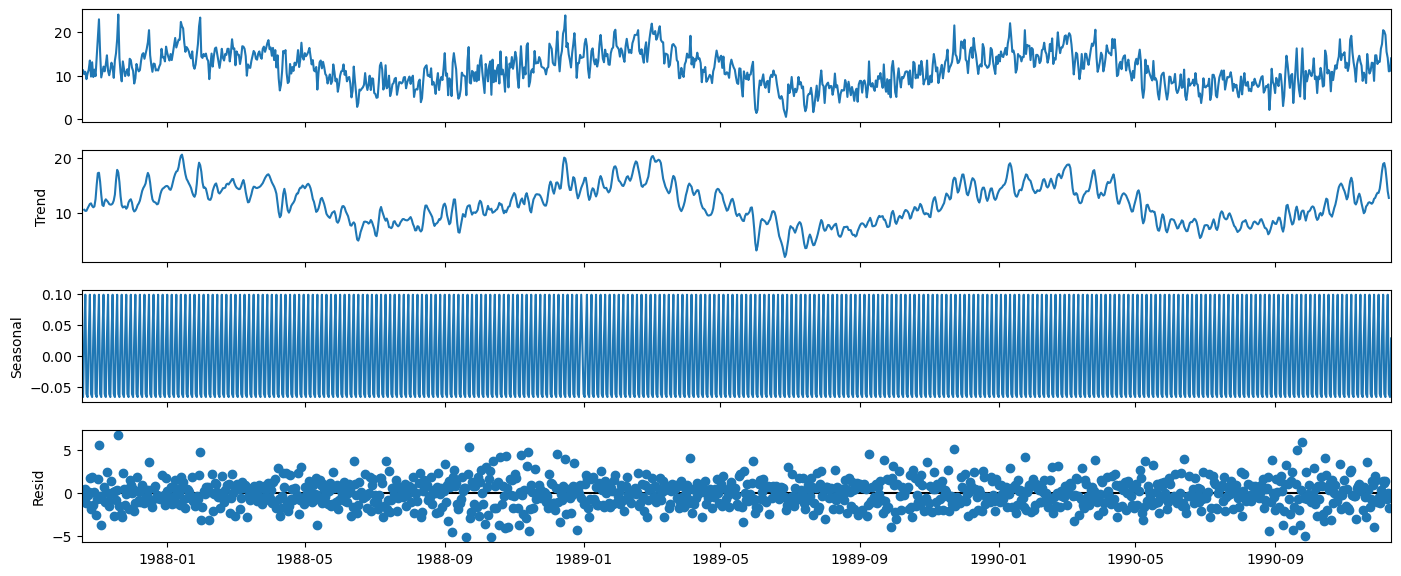

In [9]:
parts = seasonal_decompose(df, period=4)
fig = parts.plot()
fig.set_size_inches(15, 6)

Постройте SARIMA-модель ряда, подобрав параметры с лучшей метрикой AIC, и выведите ее график

Подберём начальные параметры для SARIMA:

s (длина сезона) - очевидно, 4 месяца

Для определения p, P и q, Q построим графики частной и полной автокорреляции:

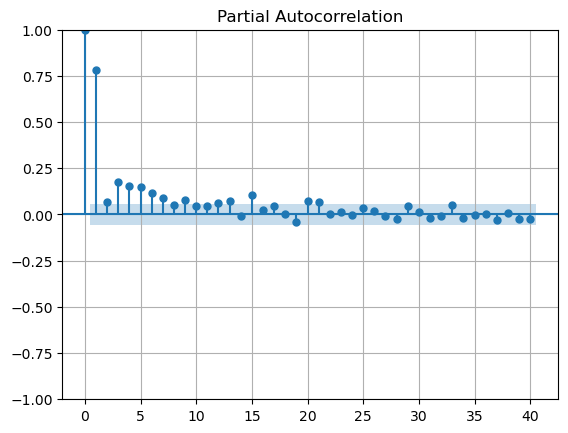

In [11]:
plot_pacf(df, lags=40)
plt.grid(True)
plt.show()

По графику PACF кажется, что:

p (кол-во компонент авторегрессии, кол-во первых значимых лагов) - 1

P (кол-во компонент авторегрессии в сезонности, кол-во значимых лагов на интервале кратном сезонности) - 2

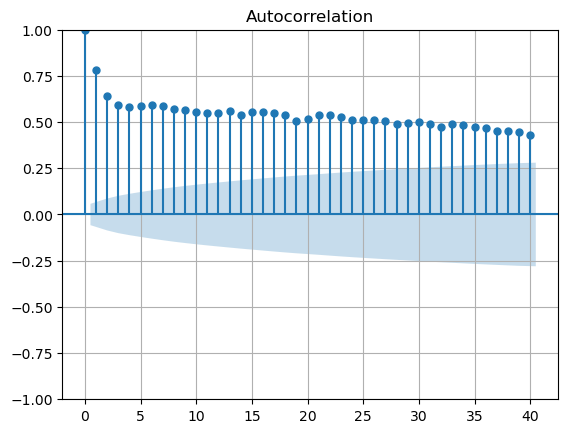

In [13]:
plot_acf(df, lags=40)
plt.grid(True)
plt.show()

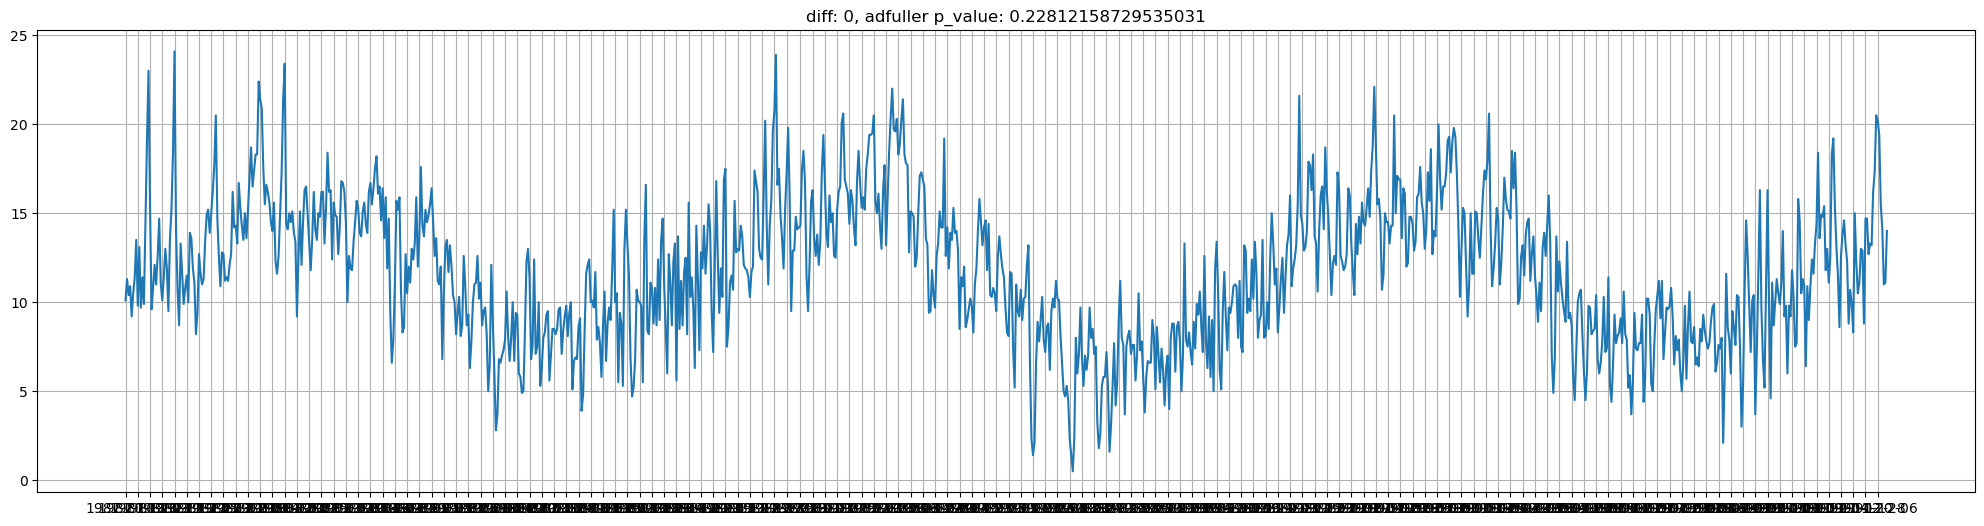

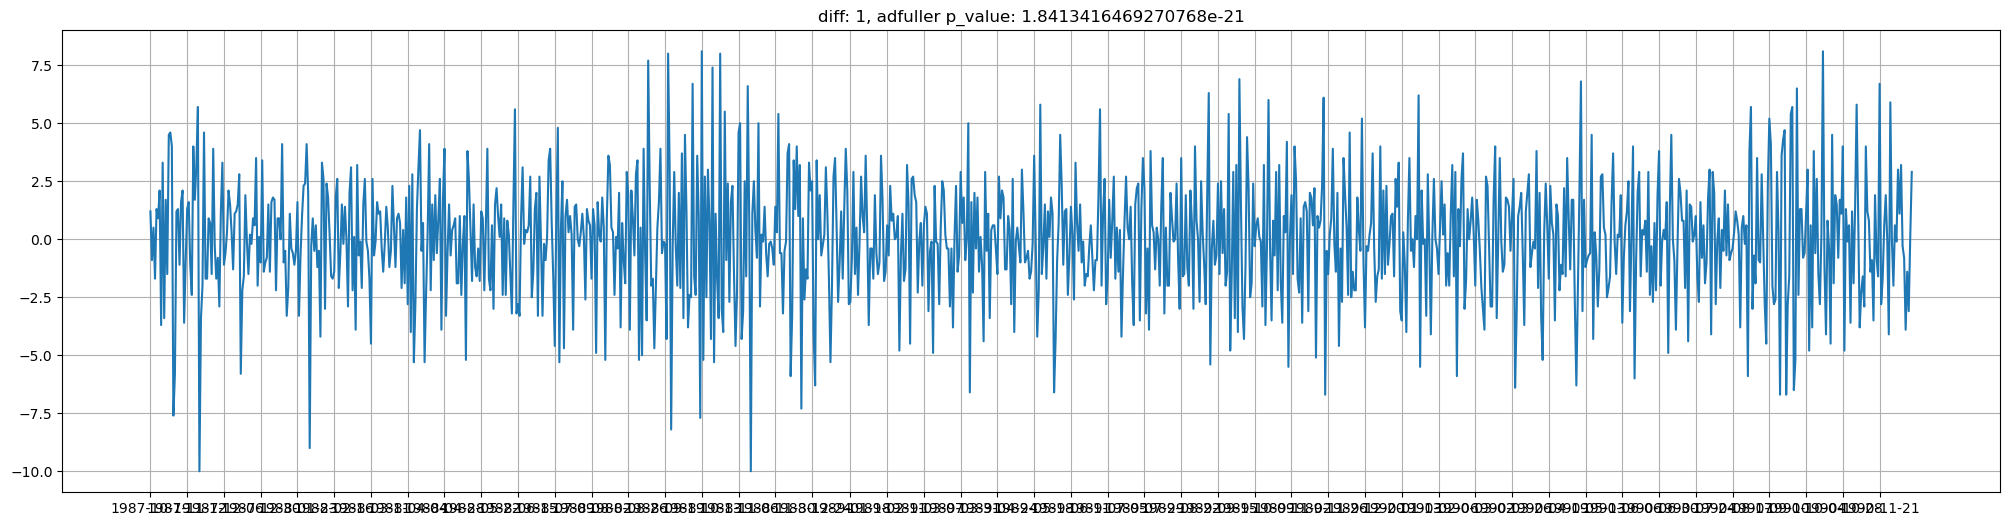

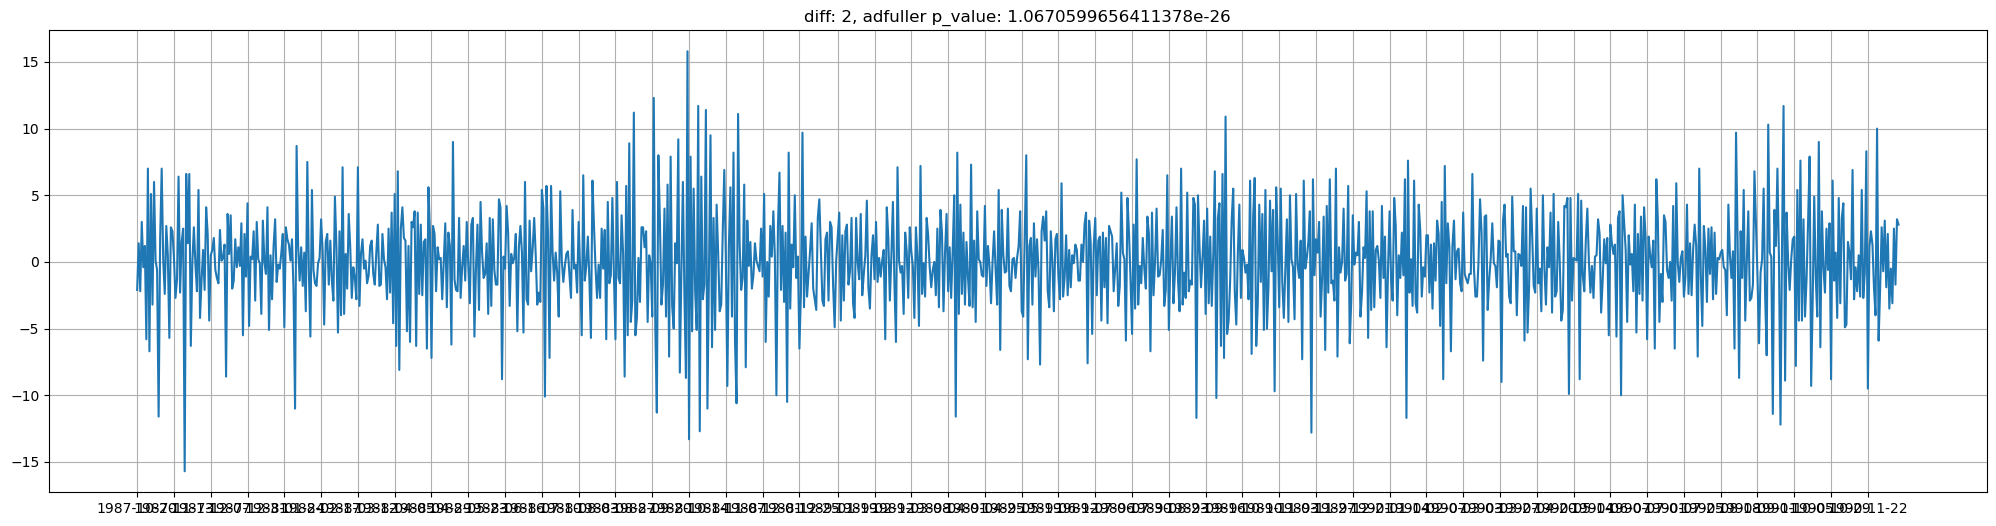

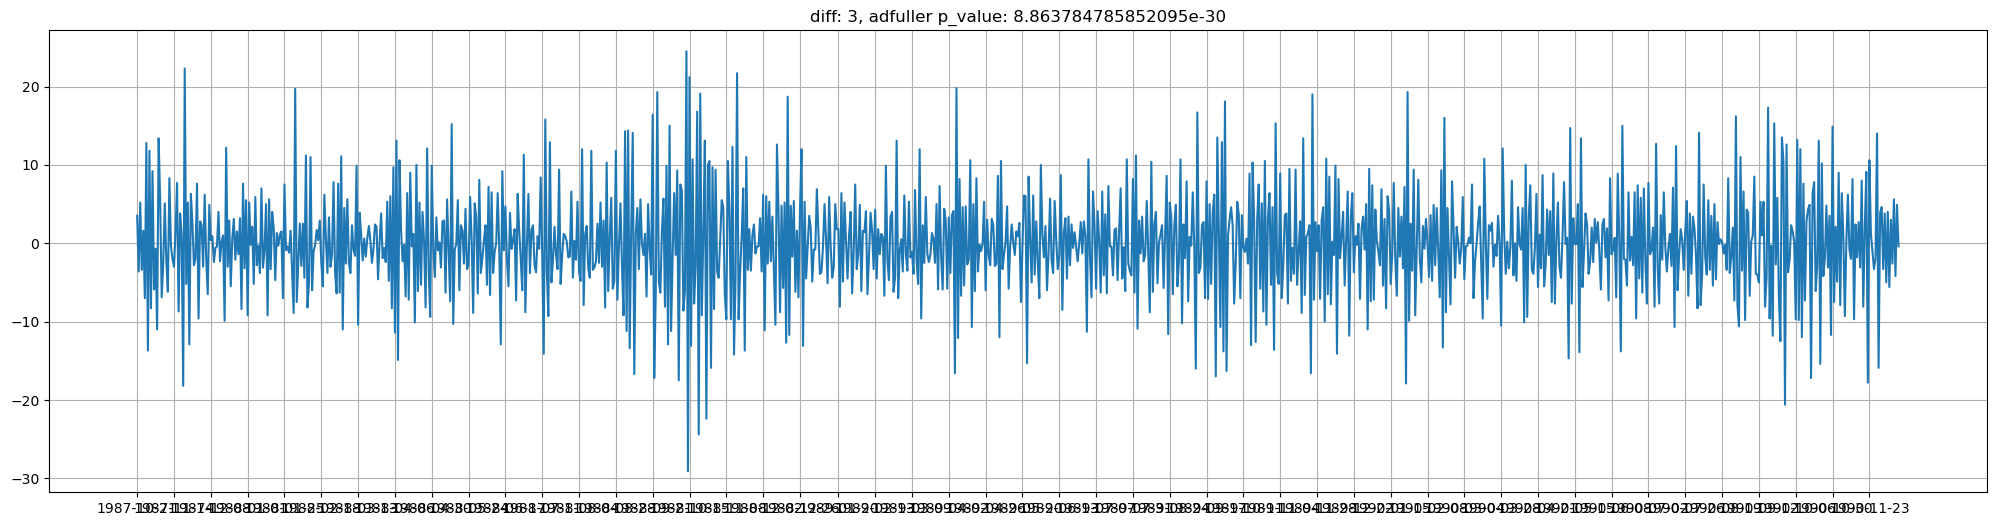

In [46]:
# Теперь посчитаем разности для определения d
prev_diff = diff = df

plt.figure(figsize=(25, 6))
plt.plot(diff['temp'])
plt.xticks([diff.index[i] for i in range(0, len(diff), 8)])
plt.title(f'diff: 0, adfuller p_value: {adfuller(diff)[1]}')  # проверяем стационарность тестом Дики-Фуллера
plt.grid(True)
plt.show()

# построим разности вплоть до 3-го порядка для проверки

for i in range(3):
    prev_diff = diff
    diff = prev_diff - prev_diff.shift(1)
    diff = diff.dropna()
    plt.figure(figsize=(25, 6))
    plt.plot(diff['temp'])
    plt.xticks([diff.index[i] for i in range(0, len(diff), 24)])
    plt.title(f'diff: {i + 1}, adfuller p_value: {adfuller(diff)[1]}')
    plt.grid(True)
    plt.show()

Уже первая разность, очевидно, стационарна, поэтому берём d = D = 1

In [17]:
# буква X в названии модели - это возможность использования экзогенной регрессии 

model = SARIMAX(
    df['temp'], 
    order=(2, 1, 3),  # p, d, q
    seasonal_order=(2, 2, 2, 8)  # P, D, Q, s
).fit(disp=False)

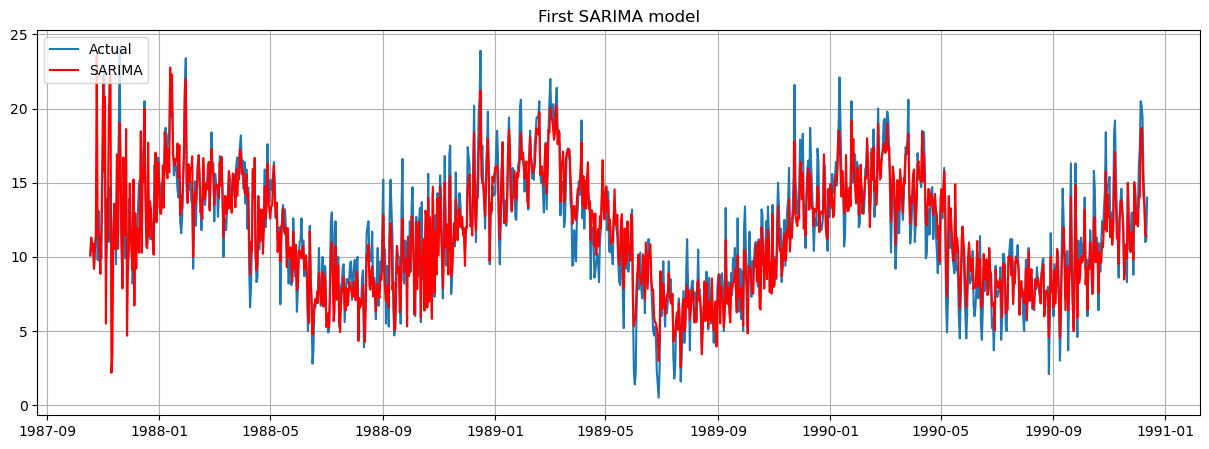

In [19]:
# надо сдвинуть на d = 1, т.к. разность съедает 1 шаг
df['naive_sarima'] = model.fittedvalues.shift(-1)

plt.figure(figsize=(15, 5))
plt.title("First SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(df['naive_sarima'], "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [21]:
model.mae, model.mse

(2.0815199349111255, 7.415383257170133)

Теперь попробуем перебрать по несколько значений параметров вокруг наших прикидочных

In [23]:
from itertools import product

ps = [1, 2, 3]
ds = [1]
qs = [2, 3, 4]
Ps = [1, 2, 3]
Ds = [1]
Qs = [2, 3, 4]
ss = [12]

parameters_list = list(product(ps, ds, qs, Ps, Ds, Qs, ss))
print(f'Всего наборов параметров: {len(parameters_list)}')

Всего наборов параметров: 81


In [25]:
from tqdm import tqdm

results = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'mae', 'mse', 'aic'])

best_aic = 100500
best_model = None

for params in tqdm(parameters_list):
    # с некоторыми параметрами модель может не сойтись
    try:
        model = SARIMAX(
            df['temp'], 
            order=params[:3],  # p, d, q
            seasonal_order=params[3:]  # P, D, Q, s
        ).fit(disp=False)
    except:
        continue

    # сохраним лучшую модель
    if model.aic < best_aic:
        best_aic = model.aic
        best_model = model
    
    current_res = pd.DataFrame({
        'p': [params[0]],
        'd': [params[1]],
        'q': [params[2]],
        'P': [params[3]],
        'D': [params[4]],
        'Q': [params[5]],
        's': [params[6]],
        'mae': [model.mae],
        'mse': [model.mse],
        'aic': [model.aic]
    })
    results = pd.concat([results, current_res])


00%|████████████████████████████████████████████████████████████████████████████████| 81/81 [1:34:31<00:00, 70.02s/it]

In [31]:
results = results.sort_values(by='aic')
results.head()

,p,d,q,P,D,Q,s,mae,mse,aic
0,1,1,2,3,1,4,12,1.880388,5.750990,5201.388186
0,1,1,3,3,1,4,12,1.875158,5.740093,5201.658110
0,3,1,2,3,1,4,12,1.876160,5.735210,5202.709634
0,2,1,3,3,1,4,12,1.876344,5.736651,5203.013404
0,1,1,2,2,1,3,12,1.883252,5.781113,5203.415343


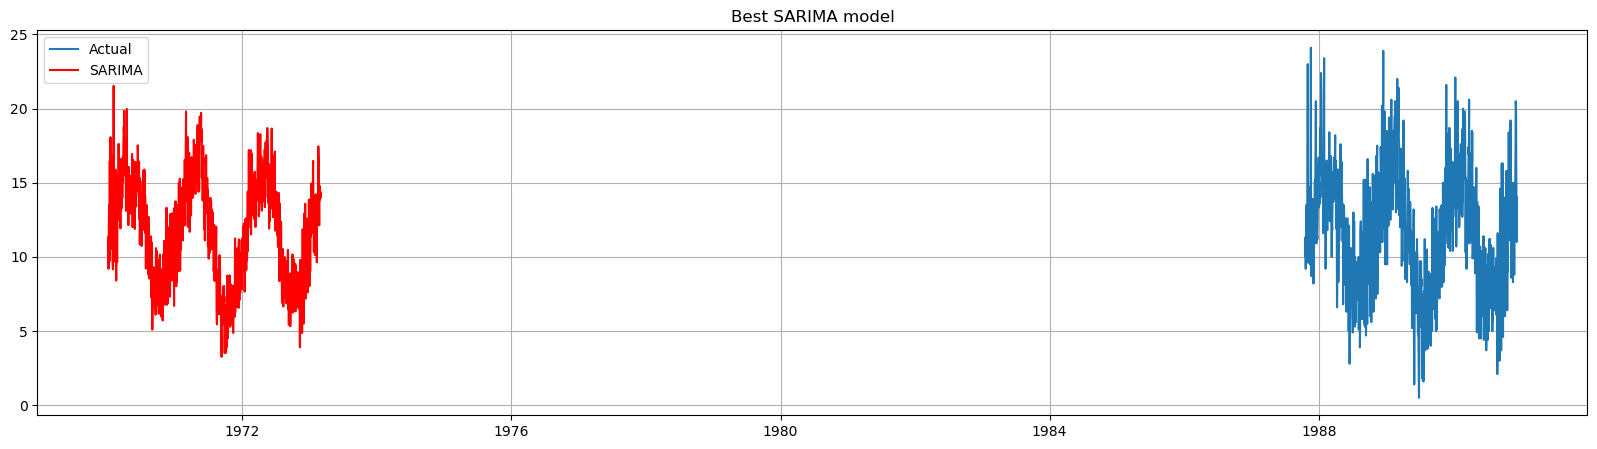

In [47]:
prediction_period = 7

predicted = best_model.predict(1, end=len(df) + prediction_period).shift(-1)

plt.figure(figsize=(20, 5))
plt.title("Best SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(predicted, "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Генерация фич и предсказание бустингом

In [52]:
# сразу добавим лаги

df_features = df.drop(columns=['naive_sarima']).copy()

for lag in range(7, 14, 1):
    df_features[f'lag_{lag}'] = df_features['temp'].shift(lag)

In [55]:
df_features.tail(7)

,temp,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
date,,,,,,,,
1990-12-06,20.2,14.7,14.7,8.8,12.9,13.0,11.1,10.5
1990-12-07,19.4,12.7,14.7,14.7,8.8,12.9,13.0,11.1
1990-12-08,15.5,13.3,12.7,14.7,14.7,8.8,12.9,13.0
1990-12-09,14.1,13.2,13.3,12.7,14.7,14.7,8.8,12.9
1990-12-10,11.0,16.2,13.2,13.3,12.7,14.7,14.7,8.8
1990-12-11,11.1,17.3,16.2,13.2,13.3,12.7,14.7,14.7
1990-12-12,14.0,20.5,17.3,16.2,13.2,13.3,12.7,14.7


In [63]:
from math import sin, cos, pi

df_features['dayofyear'] = [date.dayofyear for date in df.index]
df_features['date_sin'] = [sin(day * 2 * pi / 365) for day in df_features['dayofyear']]
df_features['date_cos'] = [cos(day * 2 * pi / 365) for day in df_features['dayofyear']]

In [68]:
import numpy as np

df_features['mean_7_14'] = [df['temp'].iloc[i - 48:i - 36].mean() if i >= 48 else np.nan for i in range(len(df))]
df_features['mean_7_14'] = [df['temp'].iloc[i - 72:i - 36].mean() if i >= 72 else np.nan for i in range(len(df))]

df_features['min_7_14'] = [df['temp'].iloc[i - 48:i - 36].min() if i >= 48 else np.nan for i in range(len(df))]
df_features['min_7_14'] = [df['temp'].iloc[i - 72:i - 36].min() if i >= 72 else np.nan for i in range(len(df))]

df_features['max_7_14'] = [df['temp'].iloc[i - 48:i - 36].max() if i >= 48 else np.nan for i in range(len(df))]
df_features['max_7_14'] = [df['temp'].iloc[i - 72:i - 36].max() if i >= 72 else np.nan for i in range(len(df))]

df_features = df_features.dropna()

In [71]:
df_features.tail(7)

,temp,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,date,month,dayofyear,date_sin,date_cos,mean_7_14,min_7_14,max_7_14
date,,,,,,,,,,,,,,,,
1990-12-06,20.2,14.7,14.7,8.8,12.9,13.0,11.1,10.5,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,340,-0.417194,0.908818,11.038889,4.6,18.4
1990-12-07,19.4,12.7,14.7,14.7,8.8,12.9,13.0,11.1,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,341,-0.401488,0.915864,10.997222,4.6,18.4
1990-12-08,15.5,13.3,12.7,14.7,14.7,8.8,12.9,13.0,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,342,-0.385663,0.922640,11.152778,4.6,18.4
1990-12-09,14.1,13.2,13.3,12.7,14.7,14.7,8.8,12.9,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,343,-0.369725,0.929141,11.352778,6.0,18.4
1990-12-10,11.0,16.2,13.2,13.3,12.7,14.7,14.7,8.8,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,344,-0.353676,0.935368,11.405556,6.0,18.4
1990-12-11,11.1,17.3,16.2,13.2,13.3,12.7,14.7,14.7,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,345,-0.337523,0.941317,11.472222,6.0,18.4
1990-12-12,14.0,20.5,17.3,16.2,13.2,13.3,12.7,14.7,<bound method Timestamp.date of Timestamp('199...,<bound method Timestamp.date of Timestamp('199...,346,-0.321270,0.946988,11.541667,6.0,18.4


In [116]:
# составим датасеты фичей и таргета

from sklearn.preprocessing import StandardScaler

# Удаляем нечисловые столбцы
extended_df = df_features.select_dtypes(include=['number'])

scaler = StandardScaler()
X_extended = scaler.fit_transform(extended_df.drop(columns=['temp']).to_numpy())

In [118]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X, Y)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

KeyError: 'xgb_result'

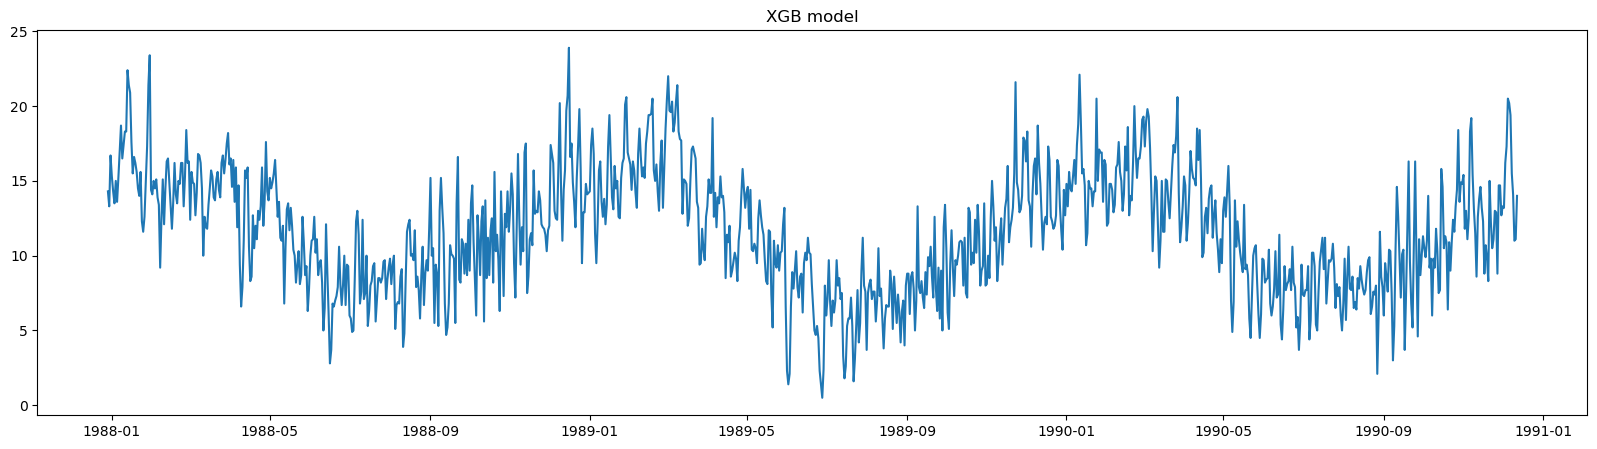

In [120]:
plt.figure(figsize=(20, 5))
plt.title("XGB model")
plt.plot(extended_df['temp'], label="Actual")
plt.plot(extended_df['xgb_result'], "r", label="XGB")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()